In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# Description of Problem

The goal of this project is to build a ML model that can classify tweets as being related to real disasters or not. Given the widespread use of social media, particularly during emergencies, it's critical for organizations like disaster relief agencies to monitor tweets and identify relevant data quickly. The challenge lies in distinguishing between tweets that use disaster-related words figuratively and those that pertain to actual events. 

This dataset consists of 10,000 hand classified tweets, with the task being to develop an NLP model that can effectively make this distinction. I've implemented various deep learning models, with a focus on RNNs. We've used a regular LSTM, along with a bi-directional version which is suitable for text classification. 

# EDA

We'll start by loading in the training and testing data.

In [2]:
trainData = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testData = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

And next we'll take a look at the header to see what fields and a sampling of data we're working with.

In [3]:
trainData.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We see we have our major fields, "target", which is set to 0 for non-disaster tweets and 1 for disaster tweets. We also have the "text" field, which is self-explanatory. We can make a histogram showing the occurences of each target in the training dataset.

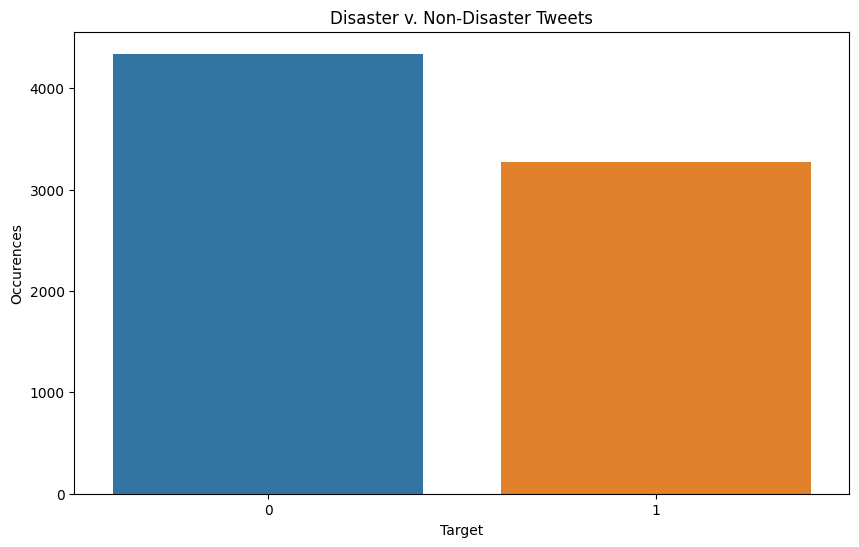

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x='target', data=trainData)
plt.title('Disaster v. Non-Disaster Tweets')
plt.xlabel('Target')
plt.ylabel('Occurences')
plt.show()

It's pretty even between the two, with a slight potential for biasing toward non-disaster classification.

We can now pre-process our data, starting with the training data. We'll set all letters to lower case, and also remove any URLs which may confuse our classifier. We'll then remove any Twitter specific attributes, like @ or #. Lastly we'll remove any other special characters, puncuation, or numbers.

In [5]:
tweetTrain = []

for tweet in trainData['text']:
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+\www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweetTrain.append(tweet)
    
trainData['cleanText'] = tweetTrain

trainData.head()

,id,keyword,location,text,target,cleanText
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


We can now see that the tweets in the "cleanText" column take on a semi-simpler form. Let's continue on to the test data.

In [6]:
tweetTest = []

for tweet in testData['text']:
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+\www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweetTest.append(tweet)
    
testData['cleanText'] = tweetTest

testData.head()

,id,keyword,location,text,cleanText
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan


To simplify the model and decrease training time, we'll use a pre-trained word embedding technique called GloVe (Global Vectors for Word Representation). Words are represented as vectors in a multidimensional space and similar words are placed closer together in that space. This captures relationships between words.

We start off by converting the tweets to sequences, then we'll pad them to ensure common length. We'll then load in the GloVe embeddings and prepare the embedding matrix.

In [7]:
maxWords = 128
maxLen = 50

tokenizer = Tokenizer(num_words = maxWords)
tokenizer.fit_on_texts(trainData['cleanText'])

sequencesTrain = tokenizer.texts_to_sequences(trainData['cleanText'])
sequencesTest = tokenizer.texts_to_sequences(testData['cleanText'])
wordIdx = tokenizer.word_index

padTrainDat = pad_sequences(sequencesTrain, maxlen = maxLen)
padTestDat = pad_sequences(sequencesTest, maxlen = maxLen)
labels = np.asarray(trainData['target'])

In [8]:
embeddingDim = 100
embeddingIdx = {}

with open(f'/kaggle/input/glove6b100dtxt/glove.6B.{embeddingDim}d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddingIdx[word] = coefs
        


In [9]:
embeddingMat = np.zeros((len(wordIdx) + 1, embeddingDim))
for word, i in wordIdx.items():
    embeddingVec = embeddingIdx.get(word)
    if embeddingVec is not None:
        embeddingMat[i] = embeddingVec

# Model Building and Training

Now that we have our embedding matrix, we can split up our training data into training and validation sets. We'll use a standard 20/80 split.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(padTrainDat, labels, test_size = 0.2, random_state = 11)

We'll begin by adding the embedded layer, with our embedded matrix previously generated using GloVe. We'll add our LSTM layer, along with a 50% dropout rate before the Dense Layer.

We'll save off two different versions of the model to determine the best number of epochs to use.

In [11]:
model = Sequential()
model.add(Embedding(len(wordIdx) + 1,
                   embeddingDim,
                   weights = [embeddingMat],
                   trainable = False))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

modelLowEpoch = model
modelHighEpoch = model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,887,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,887,100 (7.20 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,887,100 (7.20 MB)

In [12]:
history1 = modelLowEpoch.fit(X_train, y_train, epochs = 3, batch_size = 32, validation_split = 0.2)

Epoch 1/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.6544 - loss: 0.6227 - val_accuracy: 0.7176 - val_loss: 0.5702
Epoch 2/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7127 - loss: 0.5640 - val_accuracy: 0.7176 - val_loss: 0.5685
Epoch 3/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7231 - loss: 0.5541 - val_accuracy: 0.7167 - val_loss: 0.5586


In [13]:
history2 = modelHighEpoch.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7125 - loss: 0.5520 - val_accuracy: 0.6954 - val_loss: 0.5828
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7276 - loss: 0.5414 - val_accuracy: 0.7250 - val_loss: 0.5544
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7375 - loss: 0.5305 - val_accuracy: 0.7176 - val_loss: 0.5536
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7518 - loss: 0.5251 - val_accuracy: 0.7299 - val_loss: 0.5477
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7466 - loss: 0.5162 - val_accuracy: 0.7299 - val_loss: 0.5497
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7501 - loss: 0.5145 - val_accuracy: 0.7266 - val_loss: 0.5492
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7477 - loss: 0.5089 - val_accuracy: 0.7323 - val_loss: 0.5559
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7519 - loss: 0.5013 - val_ac

From this data, an Epoch of 5 seems to give the best balance between accuracy and loss. We'll use then when training our Bi-Directional LSTM model below. We'll use a similar scheme as above, but instead the LSTM layer is now bidirectional.

In [14]:
bidirectional_model = Sequential()
bidirectional_model.add(Embedding(len(wordIdx) + 1,
                   embeddingDim,
                   weights = [embeddingMat],
                   trainable = False))
bidirectional_model.add(Bidirectional(LSTM(128)))
bidirectional_model.add(Dropout(0.5))
bidirectional_model.add(Dense(1, activation = 'sigmoid'))

bidirectional_model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])


In [18]:
biHistory = bidirectional_model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

bidirectional_model.summary()

Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7349 - loss: 0.5347 - val_accuracy: 0.7176 - val_loss: 0.5527
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7430 - loss: 0.5159 - val_accuracy: 0.7020 - val_loss: 0.5707
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.7400 - loss: 0.5271 - val_accuracy: 0.7250 - val_loss: 0.5488
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.7283 - loss: 0.5256 - val_accuracy: 0.7159 - val_loss: 0.5518
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7389 - loss: 0.5217 - val_accuracy: 0.7176 - val_loss: 0.5493


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     1,887,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,361 (9.89 MB)

 Trainable params: 234,753 (917.00 KB)

 Non-trainable params: 1,887,100 (7.20 MB)

 Optimizer params: 469,508 (1.79 MB)

# Result

Before we get into the f1-scores, let's discuss our hyper-parameter tuning for the base LSTM models where we manipulated the number of Epochs used. We'll take a look at loss and accuracy.

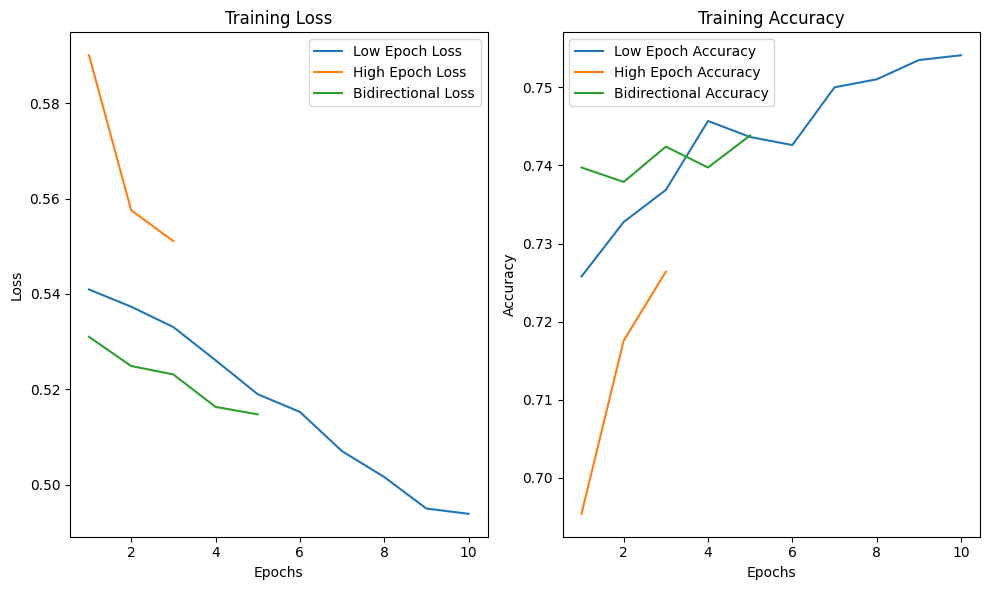

In [24]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], label='Low Epoch Loss')
plt.plot(range(1, len(history1.history['loss']) + 1), history1.history['loss'], label='High Epoch Loss')
plt.plot(range(1, len(biHistory.history['loss']) + 1), biHistory.history['loss'], label='Bidirectional Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(history2.history['accuracy']) + 1), history2.history['accuracy'], label='Low Epoch Accuracy')
plt.plot(range(1, len(history1.history['accuracy']) + 1), history1.history['accuracy'], label='High Epoch Accuracy')
plt.plot(range(1, len(biHistory.history['accuracy']) + 1), biHistory.history['accuracy'], label='Bidirectional Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

As we can see, increasing the the number of Epochs substantially decreases the LSTM model's loss, but accuracy gains are minimal with increasing processing times. We choose 5 epochs for the bidirectional model, and we prove this to be the best due to the decrease in loss, while reaching the plateu in performance.

We can now test the performance using our validation data, utilizing seaborn's classification report to review precision, precision, accuracy and f1-score.

In [16]:
yPredLowEpoch = np.round(modelLowEpoch.predict(X_val))
report1 = classification_report(y_val, yPredLowEpoch)

print(report1)

yPredHighEpoch = np.round(modelHighEpoch.predict(X_val))
report2 = classification_report(y_val, yPredHighEpoch)

print(report2)

yPredBiDir = np.round(bidirectional_model.predict(X_val))
report3 = classification_report(y_val, yPredBiDir)

print(report3)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       885
           1       0.77      0.60      0.67       638

    accuracy                           0.76      1523
   macro avg       0.76      0.73      0.74      1523
weighted avg       0.76      0.76      0.75      1523

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       885
           1       0.77      0.60      0.67       638

    accuracy                           0.76      1523
   macro avg       0.76      0.73      0.74      1523
weighted avg       0.76      0.76      0.75      1523

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       885
           1       0.73      0.64      0.68       638

    accuracy                           0.75      1523
   macro

Evidently, all three of these models perform almost identically with minute differences in performance. Overall the scores are pretty low, indicating there are a significant amount of mis-classifications. This could be due to over-fitting, and leading to a very conservative model. This model can also be too basic, and adding more LSTM layers or even stacking the layers can find higher-level features. Improving the drop out percentage could assist in this score as well. It's also possible to tune threshholds for a certain value, like f1-score, in the training process.

# Conclusion and Discussion

Since all models performed similarly, we'll chose the bidirectional LSTM to submit.

In [17]:
bestModel = bidirectional_model
bestModelPred = np.round(bestModel.predict(padTestDat)).astype(int)

modelId = pd.DataFrame(testData['id'])
merged = pd.concat([modelId, pd.DataFrame(bestModelPred, columns=['target'])], axis=1)

merged.to_csv('output.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


In the end, all models trained in this project performed fairly equal, with a precision of ~75%, recall of ~73% and f1-score of ~75%. To improve these scores we could look to improve a few different areas of the code. 

1. We could improve our pre-processing to include removing stop words to further simplify the tweets being trained on. This could improve identification of 'disaster' words.
2. We could increase model complexity by stacking LSTM layers and improving drop out placement.
3. We could also tune the f1-score threshold during the training process to further optimize.

Overall, we might want to work towards a better bidirectional model as this works best with NLP. This reads the text both forwards and backwards, so it will better understand context clues. In the end we were successful in generating different RNNs while also utilizing hyperparameter tuning to minimize loss and improve accuracy.